# Term 7 project: Inventory management
### Link to Original Github Repo: https://github.com/eg4000/SKU110K_CVPR19
### SKU-110K dataset can be found here: https://www.kaggle.com/datasets/thedatasith/sku110k-annotations/data 

In [2]:
import os
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.experimental.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import dotenv

# create your own .env file and add in your directory in the format
# SKU_DATASET_DIR = r"your_directory"
dotenv.load_dotenv()
sku_dataset_dir =  os.getenv("SKU_DATASET_DIR")
annotations_dir = Path(sku_dataset_dir) / 'annotations'
images_path = Path(sku_dataset_dir) / 'images'

2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Delete corrupted images
- List: https://github.com/eg4000/SKU110K_CVPR19/issues/99#issuecomment-988886374

In [3]:
CORRUPTED_IMAGES = {
    "train": (
              "train_1239.jpg",
              "train_2376.jpg",
              "train_2903.jpg",
              "train_2986.jpg",
              "train_305.jpg",
              "train_3240.jpg",
              "train_340.jpg",
              "train_3556.jpg",
              "train_3560.jpg",
              "train_3832.jpg",
              "train_38.jpg",
              "train_4222.jpg",
              "train_5007.jpg",
              "train_5137.jpg",
              "train_5143.jpg",
              "train_5762.jpg",
              "train_5822.jpg",
              "train_6052.jpg",
              "train_6090.jpg",
              "train_6138.jpg",
              "train_6409.jpg",
              "train_6722.jpg",
              "train_6788.jpg",
              "train_737.jpg",
              "train_7576.jpg",
              "train_7622.jpg",
              "train_775.jpg",
              "train_7883.jpg",
              "train_789.jpg",
              "train_8020.jpg",
              "train_8146.jpg",
              "train_882.jpg",
              "train_903.jpg",
              "train_924.jpg"
             ),
    "validation": (
              "val_147.jpg",
              "val_286.jpg",
              "val_296.jpg",
              "val_386.jpg"
             ),
    "test": (
              "test_132.jpg",
              "test_1346.jpg",
              "test_184.jpg",
              "test_1929.jpg",
              "test_2028.jpg",
              "test_22.jpg",
              "test_2321.jpg",
              "test_232.jpg",
              "test_2613.jpg",
              "test_2643.jpg",
              "test_274.jpg",
              "test_2878.jpg",
              "test_521.jpg",
              "test_853.jpg",
              "test_910.jpg",
              "test_923.jpg"
             ),             
}

for subset, filenames in CORRUPTED_IMAGES.items():
    for filename in filenames:
        file_path = os.path.join(images_path, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            #print(f"Removed: {file_path}")
        else:
            pass
            #print(f"File not found: {file_path}")


## Preprocessing
- addressing OOM issue: reduce image size(4160x2336 to 416, 233), limit batch size, use tensorflow api

In [4]:
from PIL import Image
import io

def load_and_preprocess_data(annotations_file, images_path, subset_size=0.01, img_size=(416, 233), batch_size=256):
    df = pd.read_csv(annotations_file)
    subset = "train" if "train" in str(annotations_file) else "validation" if "val" in str(annotations_file) else "test"
    corrupted_images = CORRUPTED_IMAGES.get(subset, [])
    df = df[~df.iloc[:, 0].isin(corrupted_images)]
    df = df.sample(frac=subset_size, random_state=42).reset_index(drop=True)

    images_path = str(images_path)  # Convert images_path to string

    def preprocess(image_name, x1, y1, x2, y2, w, h):
        image_name = image_name.numpy().decode('utf-8')
        image_path = os.path.join(images_path, image_name)

        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)  # Resize image
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]

        x1, x2 = x1 / w, x2 / w
        y1, y2 = y1 / h, y2 / h

        bbox = tf.convert_to_tensor([y1, x1, y2, x2], dtype=tf.float32)  # TensorFlow format: [ymin, xmin, ymax, xmax]
        return img, bbox

    # Convert dataframe columns to tensors
    image_names = tf.convert_to_tensor(df[df.columns[0]].values, dtype=tf.string)
    x1 = tf.convert_to_tensor(df[df.columns[1]].values.astype(float), dtype=tf.float32)
    y1 = tf.convert_to_tensor(df[df.columns[2]].values.astype(float), dtype=tf.float32)
    x2 = tf.convert_to_tensor(df[df.columns[3]].values.astype(float), dtype=tf.float32)
    y2 = tf.convert_to_tensor(df[df.columns[4]].values.astype(float), dtype=tf.float32)
    w = tf.convert_to_tensor(df[df.columns[6]].values.astype(float), dtype=tf.float32)
    h = tf.convert_to_tensor(df[df.columns[7]].values.astype(float), dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_names, x1, y1, x2, y2, w, h))
    dataset = dataset.map(lambda img, x1, y1, x2, y2, w, h: tf.py_function(preprocess, [img, x1, y1, x2, y2, w, h], [tf.float32, tf.float32]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

## Load data

In [5]:
subset_size = 0.01  # You can adjust this value as needed
img_size = (416, 233)  # Resize images to 224x224
batch_size = 64  # Number of samples per batch

train_data = load_and_preprocess_data(annotations_dir / 'annotations_train.csv', images_path, subset_size, img_size, batch_size)
val_data = load_and_preprocess_data(annotations_dir / 'annotations_val.csv', images_path, subset_size, img_size, batch_size)
test_data = load_and_preprocess_data(annotations_dir / 'annotations_test.csv', images_path, subset_size, img_size, batch_size)

2023-12-04 12:30:15.677518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 12:30:15.678156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## Visualise data

/var/folders/nf/g_pc_4zd2sx16tjwwb4r4fhm0000gn/T/ipykernel_78149/1645215618.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1, x2, y2 = row[1], row[2], row[3], row[4]


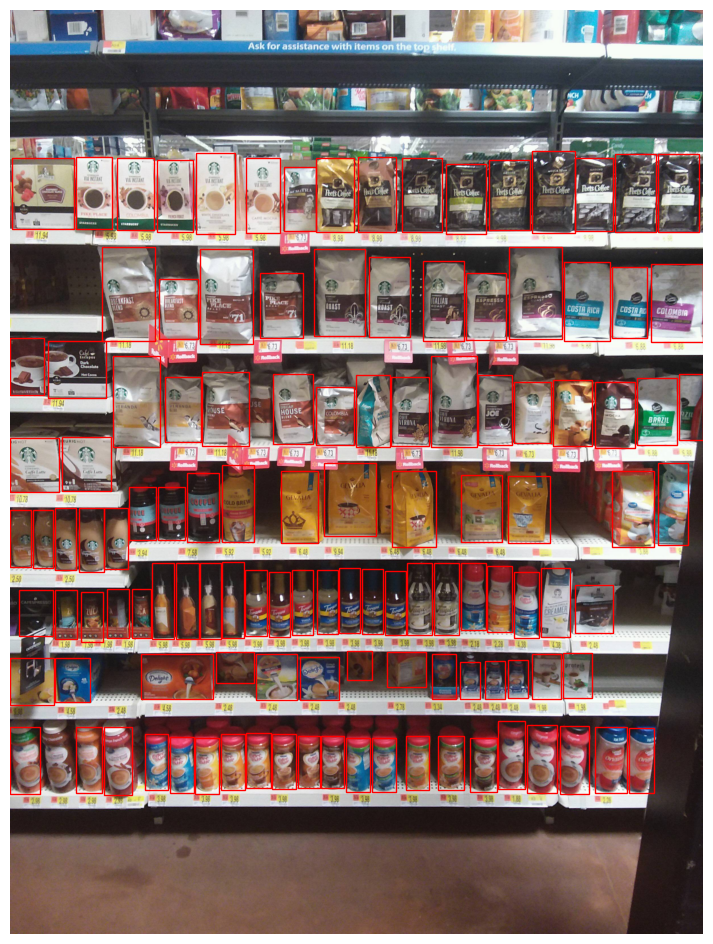

In [6]:
data_num, set = 0, 'test' 
image_num = "./"+sku_dataset_dir + rf'/images/{set}_{data_num}.jpg'
annotations_dir = Path(sku_dataset_dir) / 'annotations'
annotation_set_df = pd.read_csv('./'+sku_dataset_dir + rf'/annotations/annotations_{set}.csv')
annotation_num = annotation_set_df[annotation_set_df.iloc[:, 0] == f'{set}_{data_num}.jpg']

def display_image_with_annotations(image_path, annotations_df):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)

    # Add the bounding boxes
    for index, row in annotations_df.iterrows():
        x1, y1, x2, y2 = row[1], row[2], row[3], row[4]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Display the image with annotations
display_image_with_annotations(image_num, annotation_num)

## Train

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing

EPOCHS = 10

# VGG16 Implementation

In [7]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the VGG16 layers

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1
)

model = models.Sequential(
    [
        Input(shape=(416, 233, 3)),
        preprocessing.Resizing(224, 224, interpolation="bilinear"),
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(
            4, activation="sigmoid"
        ),  # 4 values for bounding box (x, y, width, height)
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber(),
    metrics=[
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=[cp_callback]
)
model.save("my_model_VGG.keras")

Epoch 1/10


2023-12-02 17:32:12.702948: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-02 17:32:13.487348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - ETA: 0s - loss: 0.1585 - auc: 0.6663 - precision: 0.9989 - recall: 0.4729

2023-12-02 17:44:45.967780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to training_1/cp.ckpt
189/189 [==============================] - 811s 4s/step - loss: 0.1585 - auc: 0.6663 - precision: 0.9989 - recall: 0.4729 - val_loss: 0.1507 - val_auc: 0.8137 - val_precision: 0.9993 - val_recall: 0.7525
Epoch 2/10
188/189 [============================>.] - ETA: 3s - loss: 0.1498 - auc: 0.7943 - precision: 0.9993 - recall: 0.7389
Epoch 2: saving model to training_1/cp.ckpt
189/189 [==============================] - 797s 4s/step - loss: 0.1498 - auc: 0.7943 - precision: 0.9993 - recall: 0.7389 - val_loss: 0.1507 - val_auc: 0.8139 - val_precision: 0.9993 - val_recall: 0.7528
Epoch 3/10
189/189 [==============================] - ETA: 0s - loss: 0.1488 - auc: 0.8016 - precision: 0.9995 - recall: 0.7133
Epoch 3: saving model to training_1/cp.ckpt
189/189 [==============================] - 800s 4s/step - loss: 0.1488 - auc: 0.8016 - precision: 0.9995 - recall: 0.7133 - val_loss: 0.1493 - val_auc: 0.8024 - val_precision: 0.9992 - val_recall: 0.7300

In [8]:
from tensorflow.keras.models import load_model

model = load_model('my_model_VGG.keras')
iou = tf.keras.metrics.MeanIoU(num_classes=2) 

eval_results = model.evaluate(val_data)
print("Loss on validation data:", eval_results)

predictions = model.predict(val_data)

for images, true_boxes in val_data:
    # Get model predictions
    pred_boxes = model.predict(images)
    # Update IoU metric
    iou.update_state(true_boxes, pred_boxes)

# Get the final IoU
average_iou = iou.result().numpy()
print(f'Average IoU: {average_iou}')

2023-12-02 19:42:10.831062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 52s 3s/step - loss: 0.1435 - auc: 0.7511 - precision: 1.0000 - recall: 0.5022
Loss on validation data: [0.14352793991565704, 0.7511098384857178, 1.0, 0.5022197365760803]


2023-12-02 19:43:02.908559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 52s 3s/step


2023-12-02 19:43:58.672467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 179ms/step


2023-12-02 19:44:47.571179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Average IoU: 0.2562216818332672


# ResNet50 Implementation

In [9]:
base_model_2 = ResNet50(
    weights="imagenet",
    include_top=False,  # use our own input layer for transfer learning
    input_shape=(224, 224, 3),
)

base_model_2.trainable = False

checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1
)

resnet_model = models.Sequential(
    [
        Input(shape=(416, 233, 3)),
        preprocessing.Resizing(224, 224, interpolation="bilinear"),
        base_model_2,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(
            4, activation="sigmoid"
        ),  # 4 values for bounding box (x, y, width, height)
    ]
)

resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber(),
    metrics=[
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

history = resnet_model.fit(
    train_data, epochs=EPOCHS, validation_data=val_data, callbacks=[cp_callback]
)
model.save("my_model_RESNET.keras")

Epoch 1/10


2023-12-02 19:44:51.132793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - ETA: 0s - loss: 0.1592 - auc_1: 0.2774 - precision_1: 0.9928 - recall_1: 0.4051

2023-12-02 19:55:48.409141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to training_2/cp.ckpt
189/189 [==============================] - 710s 4s/step - loss: 0.1592 - auc_1: 0.2774 - precision_1: 0.9928 - recall_1: 0.4051 - val_loss: 0.1560 - val_auc_1: 0.2854 - val_precision_1: 0.9914 - val_recall_1: 0.4467
Epoch 2/10
189/189 [==============================] - ETA: 0s - loss: 0.1571 - auc_1: 0.3281 - precision_1: 0.9942 - recall_1: 0.4997
Epoch 2: saving model to training_2/cp.ckpt
189/189 [==============================] - 716s 4s/step - loss: 0.1571 - auc_1: 0.3281 - precision_1: 0.9942 - recall_1: 0.4997 - val_loss: 0.1545 - val_auc_1: 0.3117 - val_precision_1: 0.9923 - val_recall_1: 0.4983
Epoch 3/10
189/189 [==============================] - ETA: 0s - loss: 0.1569 - auc_1: 0.3318 - precision_1: 0.9943 - recall_1: 0.5070
Epoch 3: saving model to training_2/cp.ckpt
189/189 [==============================] - 712s 4s/step - loss: 0.1569 - auc_1: 0.3318 - precision_1: 0.9943 - recall_1: 0.5070 - val_loss: 0.1532 - val_auc_1: 0.3318 

In [10]:
eval_results = model.evaluate(val_data)
print("Loss on validation data:", eval_results)

from tensorflow.keras.models import load_model

model = load_model('my_model_RESNET.keras')
iou = tf.keras.metrics.MeanIoU(num_classes=2) 

predictions = model.predict(val_data)

for images, true_boxes in val_data:
    # Get model predictions
    pred_boxes = model.predict(images)
    # Update IoU metric
    iou.update_state(true_boxes, pred_boxes)

# Get the final IoU
average_iou = iou.result().numpy()
print(f'Average IoU: {average_iou}')

15/15 [==============================] - 57s 4s/step - loss: 0.1435 - auc: 0.7511 - precision: 1.0000 - recall: 0.5022
Loss on validation data: [0.14352793991565704, 0.7511098384857178, 1.0, 0.5022197365760803]


2023-12-02 21:43:24.698460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 52s 3s/step


2023-12-02 21:44:20.128614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 229ms/step


2023-12-02 21:45:07.822861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 297ms/step
Average IoU: 0.2562216818332672


### Visualise the predictions

/var/folders/nf/g_pc_4zd2sx16tjwwb4r4fhm0000gn/T/ipykernel_78149/769849025.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(image_size[0],image_size[1])


2560 1920


2023-12-04 12:45:09.640486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 9s 9s/step


/var/folders/nf/g_pc_4zd2sx16tjwwb4r4fhm0000gn/T/ipykernel_78149/769849025.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1, x2, y2 = row[0]*image_size[0], row[1]*image_size[1], row[2]*image_size[0], row[3]*image_size[1]


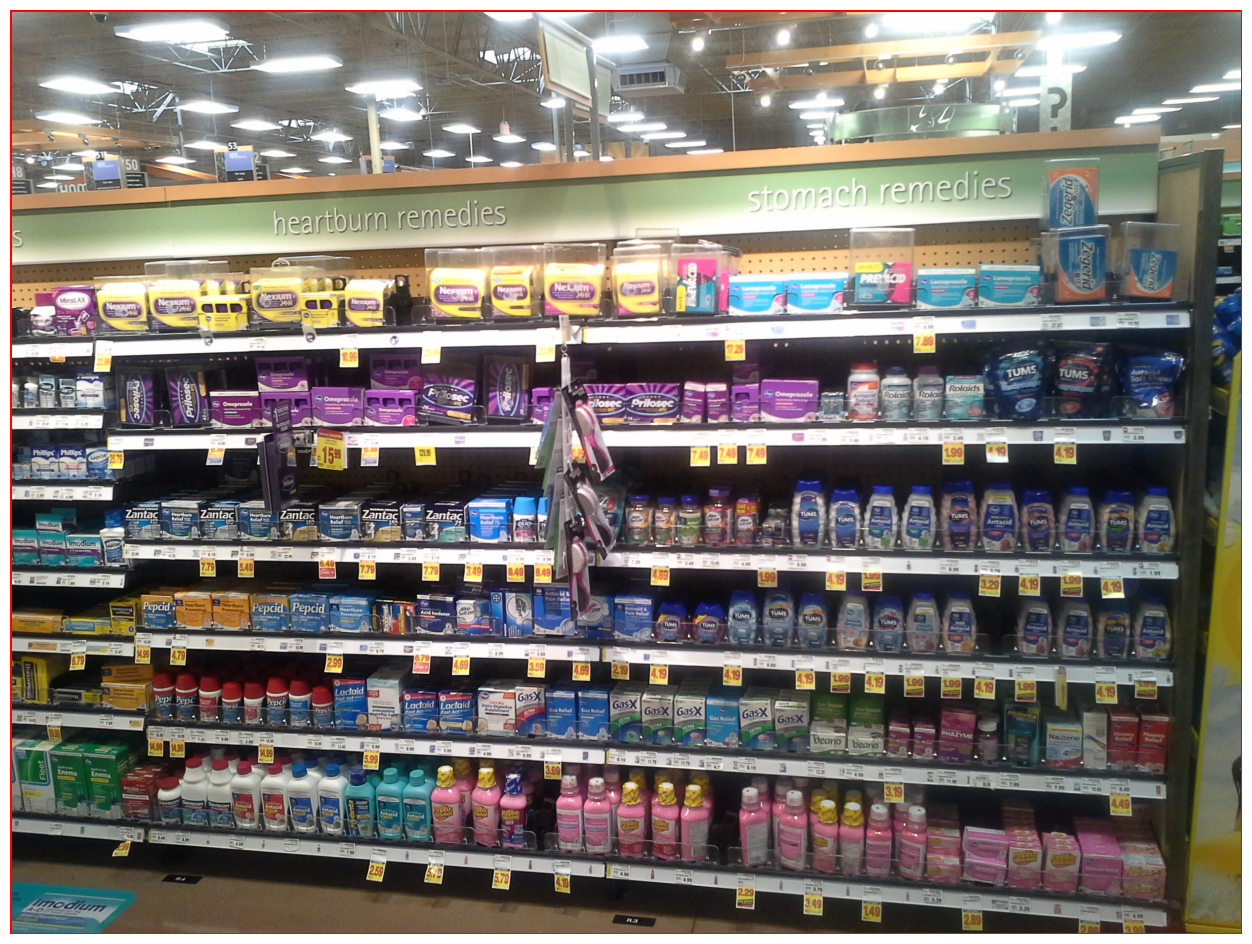

In [24]:
def load_and_preprocess_one(annotations_file, images_path,image_name, img_size=(416, 233), batch_size=256):
    df = pd.read_csv(annotations_file)
    subset = "train" if "train" in str(annotations_file) else "validation" if "val" in str(annotations_file) else "test"
    corrupted_images = CORRUPTED_IMAGES.get(subset, [])
    df = df[~df.iloc[:, 0].isin(corrupted_images)]
    df = df[df.iloc[:, 0] == image_name]

    images_path = str(images_path)  # Convert images_path to string

    def preprocess(image_name, x1, y1, x2, y2, w, h):
        image_name = image_name.numpy().decode('utf-8')
        image_path = os.path.join(images_path, image_name)

        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)  # Resize image
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]

        x1, x2 = x1 / w, x2 / w
        y1, y2 = y1 / h, y2 / h

        bbox = tf.convert_to_tensor([y1, x1, y2, x2], dtype=tf.float32)  # TensorFlow format: [ymin, xmin, ymax, xmax]
        return img, bbox

    # Convert dataframe columns to tensors
    image_names = tf.convert_to_tensor(df[df.columns[0]].values, dtype=tf.string)
    x1 = tf.convert_to_tensor(df[df.columns[1]].values.astype(float), dtype=tf.float32)
    y1 = tf.convert_to_tensor(df[df.columns[2]].values.astype(float), dtype=tf.float32)
    x2 = tf.convert_to_tensor(df[df.columns[3]].values.astype(float), dtype=tf.float32)
    y2 = tf.convert_to_tensor(df[df.columns[4]].values.astype(float), dtype=tf.float32)
    w = tf.convert_to_tensor(df[df.columns[6]].values.astype(float), dtype=tf.float32)
    h = tf.convert_to_tensor(df[df.columns[7]].values.astype(float), dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_names, x1, y1, x2, y2, w, h))
    dataset = dataset.map(lambda img, x1, y1, x2, y2, w, h: tf.py_function(preprocess, [img, x1, y1, x2, y2, w, h], [tf.float32, tf.float32]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

from tensorflow.keras.models import load_model

data_num, set = 166, 'val' 
image_num = "./"+sku_dataset_dir + rf'/images/{set}_{data_num}.jpg'
annotations_dir = Path(sku_dataset_dir) / 'annotations'
annotation_set_df = pd.read_csv('./'+sku_dataset_dir + rf'/annotations/annotations_{set}.csv')
annotation_num = annotation_set_df[annotation_set_df.iloc[:, 0] == f'{set}_{data_num}.jpg']
image_size = annotation_num.iloc[0,6:8]
print(image_size[0],image_size[1])

test_one= load_and_preprocess_one(annotations_dir / rf'annotations_{set}.csv', images_path ,rf'{set}_{data_num}.jpg' , img_size=(416, 233), batch_size=256)

model = load_model('Huber_Resnet.keras')
out = model.predict(test_one)


def display_image_with_annotations_pred(image_path, annotations, image_size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)

    # Add the bounding boxes
    for row in annotations:
        x1, y1, x2, y2 = row[0]*image_size[0], row[1]*image_size[1], row[2]*image_size[0], row[3]*image_size[1]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

display_image_with_annotations_pred(image_num,out,image_size)